# Análise de Sentimentos IMDB - Prova de Conceito (PoC) Completa

Este notebook demonstra a viabilidade do uso de machine learning para análise de sentimentos em reviews do IMDB.

## Objetivos:
1. Carregar e explorar o dataset IMDB
2. Realizar análise exploratória de dados abrangente
3. Construir e avaliar múltiplos modelos de análise de sentimentos
4. Demonstrar arquitetura modular de pipeline
5. Validar a abordagem com dados reais

In [ ]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 1. Carregamento e Exploração Inicial dos Dados

In [ ]:
# Carregar o dataset IMDB
print("Carregando dataset IMDB...")
df = pd.read_csv('IMDB Dataset.csv')

print(f"\n{'='*60}")
print("INFORMAÇÕES GERAIS DO DATASET")
print(f"{'='*60}")
print(f"\nDimensões do dataset: {df.shape[0]:,} linhas x {df.shape[1]} colunas")
print(f"\nPrimeiras linhas:")
print(df.head())

print(f"\n{'='*60}")
print("INFORMAÇÕES TÉCNICAS")
print(f"{'='*60}")
print(df.info())

print(f"\n{'='*60}")
print("VERIFICAÇÃO DE QUALIDADE DOS DADOS")
print(f"{'='*60}")
print(f"\nDados faltantes:")
print(df.isnull().sum())
print(f"\nDuplicatas: {df.duplicated().sum()}")

print(f"\n{'='*60}")
print("DISTRIBUIÇÃO DE SENTIMENTOS")
print(f"{'='*60}")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)
print(f"\nPositivos: {sentiment_counts['positive']:,} ({sentiment_counts['positive']/len(df)*100:.2f}%)")
print(f"Negativos: {sentiment_counts['negative']:,} ({sentiment_counts['negative']/len(df)*100:.2f}%)")
print(f"\nDataset balanceado: {'Sim' if abs(sentiment_counts['positive'] - sentiment_counts['negative']) < 100 else 'Não'}")

Carregando dataset IMDB...

INFORMAÇÕES GERAIS DO DATASET

Dimensões do dataset: 50,000 linhas x 2 colunas

Primeiras linhas:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

INFORMAÇÕES TÉCNICAS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

VERIFICAÇÃO DE QUALIDADE DOS DADOS

Dados faltantes:
review       0
sentiment    0
dtype: int64

Duplicatas: 418

DISTRIBUIÇÃO DE SENTIMENTOS
sentiment
positive  

## 2. Análise Exploratória de Dados Detalhada

In [ ]:
# Criar variáveis de análise
df['comprimento_texto'] = df['review'].apply(len)
df['contagem_palavras'] = df['review'].apply(lambda x: len(x.split()))
df['comprimento_medio_palavra'] = df['review'].apply(lambda x: np.mean([len(word) for word in x.split()]))

# Mapear sentimentos para numérico
df['sentiment_num'] = df['sentiment'].map({'positive': 1, 'negative': 0})

print(f"\n{'='*60}")
print("ESTATÍSTICAS DE COMPRIMENTO DE TEXTO")
print(f"{'='*60}")
print(f"\nComprimento de caracteres:")
print(df['comprimento_texto'].describe())

print(f"\nContagem de palavras:")
print(df['contagem_palavras'].describe())

print(f"\nComprimento médio de palavra:")
print(df['comprimento_medio_palavra'].describe())

print(f"\n{'='*60}")
print("COMPARAÇÃO POR SENTIMENTO")
print(f"{'='*60}")
print(f"\nEstatísticas de comprimento por sentimento:")
print(df.groupby('sentiment')[['comprimento_texto', 'contagem_palavras', 'comprimento_medio_palavra']].describe())


ESTATÍSTICAS DE COMPRIMENTO DE TEXTO

Comprimento de caracteres:
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: comprimento_texto, dtype: float64

Contagem de palavras:
count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: contagem_palavras, dtype: float64

Comprimento médio de palavra:
count    50000.000000
mean         4.640676
std          0.340731
min          1.239865
25%          4.417904
50%          4.627006
75%          4.847458
max         12.290909
Name: comprimento_medio_palavra, dtype: float64

COMPARAÇÃO POR SENTIMENTO

Estatísticas de comprimento por sentimento:
          comprimento_texto                                               \
                      count        mean          std   min    25%    50%   


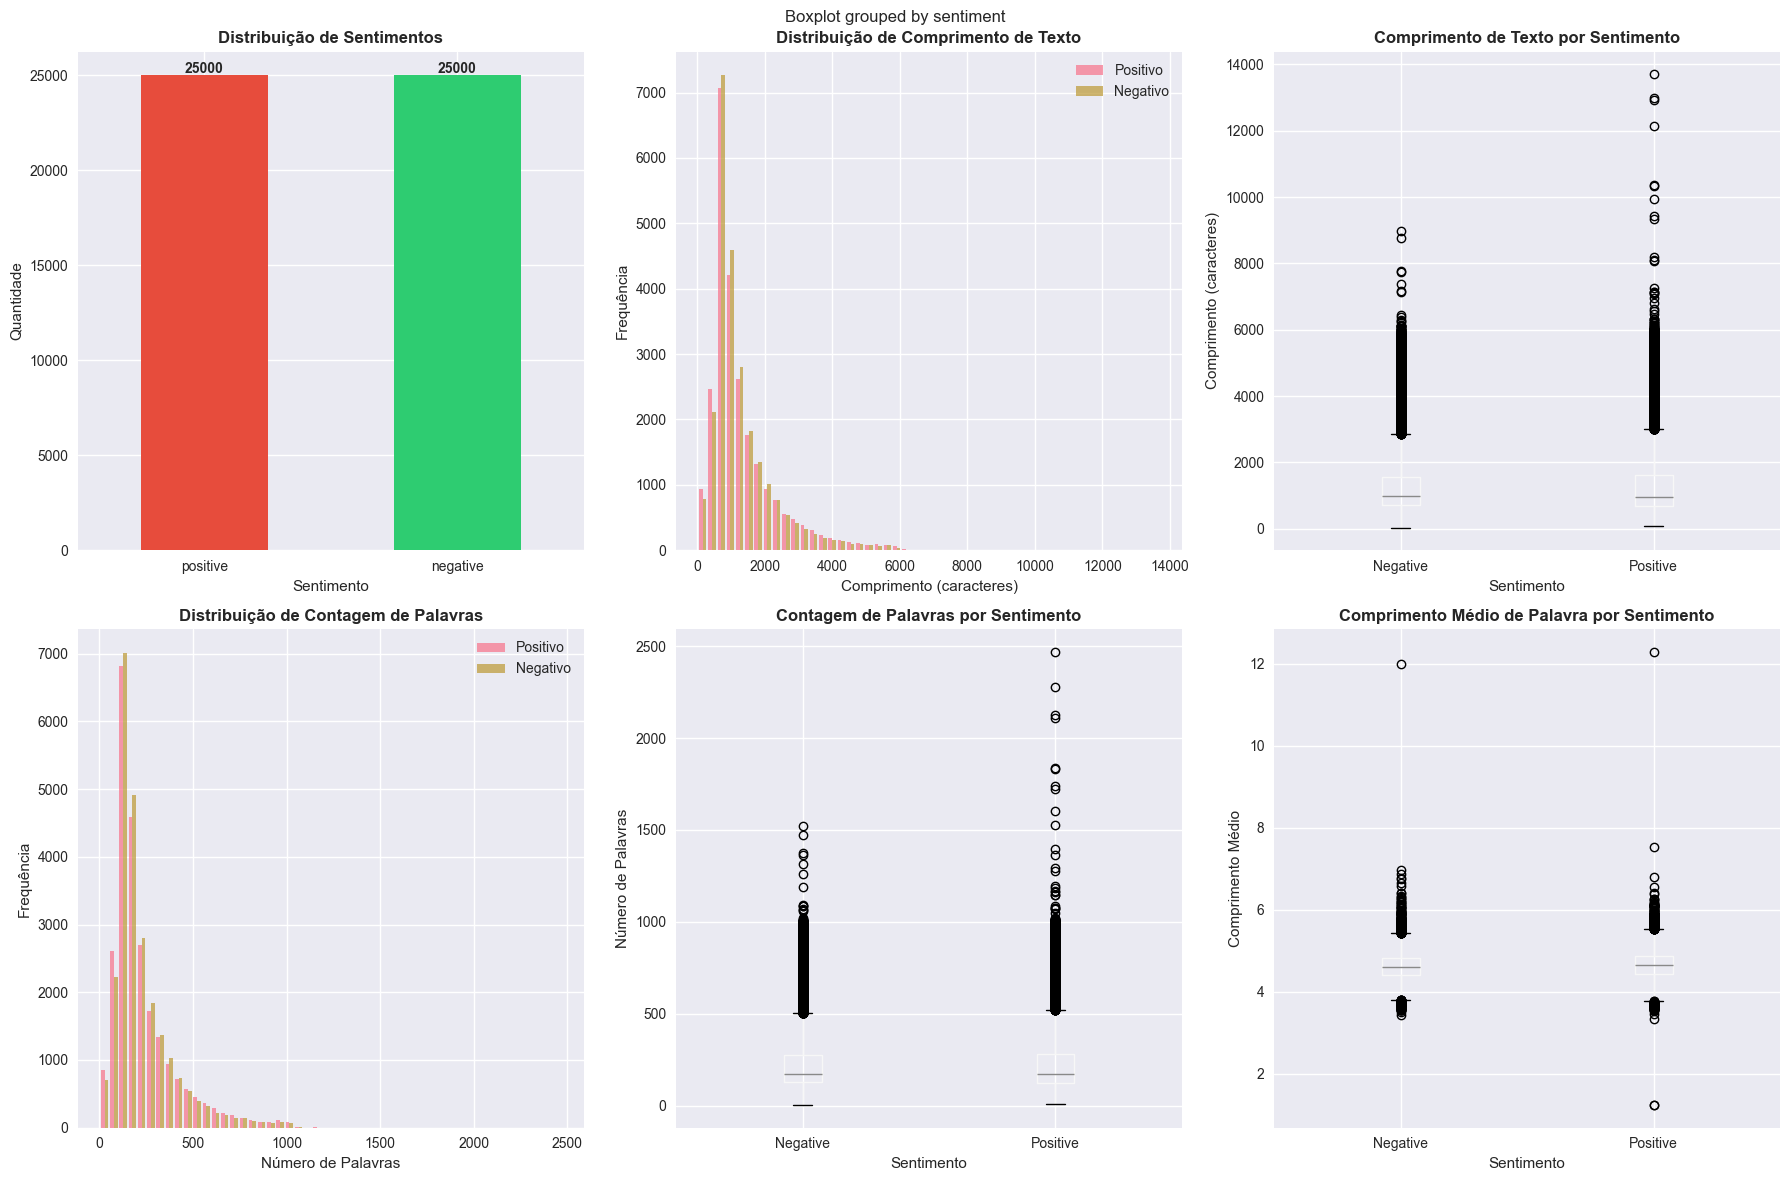

In [ ]:
# Visualizações
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análise Exploratória de Dados - Dataset IMDB', fontsize=16, fontweight='bold')

# 1. Distribuição de sentimentos
df['sentiment'].value_counts().plot(kind='bar', ax=axes[0,0], color=['#e74c3c', '#2ecc71'])
axes[0,0].set_title('Distribuição de Sentimentos', fontweight='bold')
axes[0,0].set_xlabel('Sentimento')
axes[0,0].set_ylabel('Quantidade')
axes[0,0].tick_params(axis='x', rotation=0)
for i, v in enumerate(df['sentiment'].value_counts()):
    axes[0,0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# 2. Distribuição de comprimento de texto
axes[0,1].hist([df[df['sentiment']=='positive']['comprimento_texto'],
                df[df['sentiment']=='negative']['comprimento_texto']],
               bins=50, label=['Positivo', 'Negativo'], alpha=0.7)
axes[0,1].set_title('Distribuição de Comprimento de Texto', fontweight='bold')
axes[0,1].set_xlabel('Comprimento (caracteres)')
axes[0,1].set_ylabel('Frequência')
axes[0,1].legend()

# 3. Boxplot de comprimento por sentimento
df.boxplot(column='comprimento_texto', by='sentiment', ax=axes[0,2])
axes[0,2].set_title('Comprimento de Texto por Sentimento', fontweight='bold')
axes[0,2].set_xlabel('Sentimento')
axes[0,2].set_ylabel('Comprimento (caracteres)')
plt.sca(axes[0,2])
plt.xticks([1, 2], ['Negative', 'Positive'])

# 4. Distribuição de contagem de palavras
axes[1,0].hist([df[df['sentiment']=='positive']['contagem_palavras'],
                df[df['sentiment']=='negative']['contagem_palavras']],
               bins=50, label=['Positivo', 'Negativo'], alpha=0.7)
axes[1,0].set_title('Distribuição de Contagem de Palavras', fontweight='bold')
axes[1,0].set_xlabel('Número de Palavras')
axes[1,0].set_ylabel('Frequência')
axes[1,0].legend()

# 5. Boxplot de contagem de palavras
df.boxplot(column='contagem_palavras', by='sentiment', ax=axes[1,1])
axes[1,1].set_title('Contagem de Palavras por Sentimento', fontweight='bold')
axes[1,1].set_xlabel('Sentimento')
axes[1,1].set_ylabel('Número de Palavras')
plt.sca(axes[1,1])
plt.xticks([1, 2], ['Negative', 'Positive'])

# 6. Comprimento médio de palavra
df.boxplot(column='comprimento_medio_palavra', by='sentiment', ax=axes[1,2])
axes[1,2].set_title('Comprimento Médio de Palavra por Sentimento', fontweight='bold')
axes[1,2].set_xlabel('Sentimento')
axes[1,2].set_ylabel('Comprimento Médio')
plt.sca(axes[1,2])
plt.xticks([1, 2], ['Negative', 'Positive'])

plt.tight_layout()
plt.show()


ANÁLISE DE PALAVRAS MAIS FREQUENTES

15 palavras mais comuns em reviews POSITIVAS:
 1. film            - 39422 ocorrências
 2. movie           - 36037 ocorrências
 3. you             - 28994 ocorrências
 4. one             - 25735 ocorrências
 5. very            - 16029 ocorrências
 6. more            - 14539 ocorrências
 7. good            - 14352 ocorrências
 8. some            - 14248 ocorrências
 9. great           - 12643 ocorrências
10. story           - 12380 ocorrências
11. see             - 11866 ocorrências
12. well            - 10976 ocorrências
13. really          - 10674 ocorrências
14. most            -  9437 ocorrências
15. even            -  9364 ocorrências

15 palavras mais comuns em reviews NEGATIVAS:
 1. movie           - 47513 ocorrências
 2. film            - 35065 ocorrências
 3. you             - 30166 ocorrências
 4. one             - 24642 ocorrências
 5. some            - 16389 ocorrências
 6. even            - 14912 ocorrências
 7. good            - 14144 o

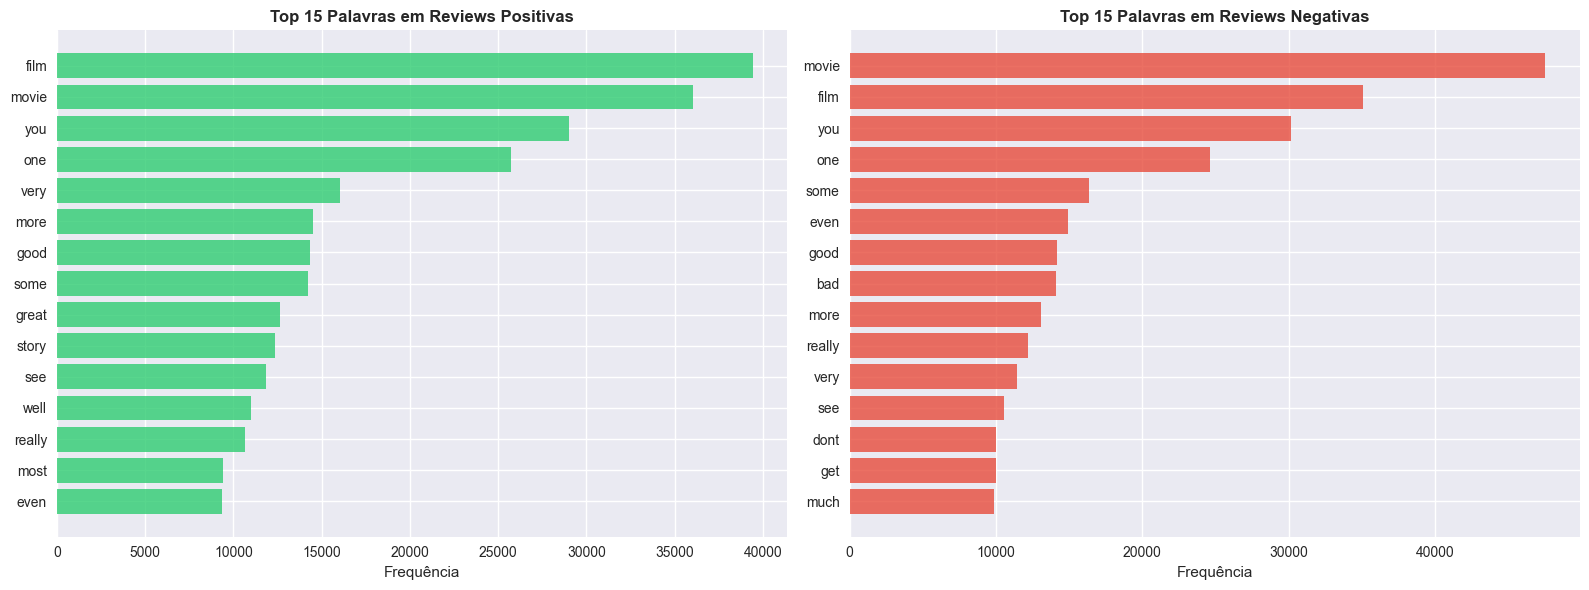

In [ ]:
# Análise de palavras mais comuns
def obter_palavras_mais_comuns(series_texto, top_n=15, remover_stopwords=True):
    """Extrai as palavras mais comuns de uma série de textos."""
    texto_completo = ' '.join(series_texto).lower()
    # Remover HTML tags e caracteres especiais
    texto_completo = re.sub(r'<[^>]+>', '', texto_completo)
    texto_completo = re.sub(r'[^a-zA-Z\s]', '', texto_completo)
    palavras = texto_completo.split()

    if remover_stopwords:
        stopwords = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
                        'of', 'with', 'by', 'is', 'it', 'this', 'that', 'was', 'were', 'are',
                        'as', 'has', 'have', 'had', 'be', 'been', 'not', 'also', 'than', 'its',
                        'from', 'they', 'them', 'their', 'what', 'which', 'who', 'when', 'where',
                        'how', 'all', 'each', 'she', 'he', 'him', 'her', 'his', 'can', 'will',
                        'just', 'don', 't', 's', 'if', 'would', 'make', 'like', 'time', 'about',
                        'out', 'up', 'there', 'so', 'only', 'no', 'way', 'could', 'people'])
        palavras = [p for p in palavras if p not in stopwords and len(p) > 2]

    contagem = Counter(palavras)
    return contagem.most_common(top_n)

print(f"\n{'='*60}")
print("ANÁLISE DE PALAVRAS MAIS FREQUENTES")
print(f"{'='*60}")

print(f"\n15 palavras mais comuns em reviews POSITIVAS:")
palavras_positivas = obter_palavras_mais_comuns(df[df['sentiment']=='positive']['review'])
for i, (palavra, freq) in enumerate(palavras_positivas, 1):
    print(f"{i:2d}. {palavra:15s} - {freq:5d} ocorrências")

print(f"\n15 palavras mais comuns em reviews NEGATIVAS:")
palavras_negativas = obter_palavras_mais_comuns(df[df['sentiment']=='negative']['review'])
for i, (palavra, freq) in enumerate(palavras_negativas, 1):
    print(f"{i:2d}. {palavra:15s} - {freq:5d} ocorrências")

# Visualizar palavras mais comuns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Palavras positivas
palavras_pos, freq_pos = zip(*palavras_positivas)
axes[0].barh(palavras_pos, freq_pos, color='#2ecc71', alpha=0.8)
axes[0].set_title('Top 15 Palavras em Reviews Positivas', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Frequência')
axes[0].invert_yaxis()

# Palavras negativas
palavras_neg, freq_neg = zip(*palavras_negativas)
axes[1].barh(palavras_neg, freq_neg, color='#e74c3c', alpha=0.8)
axes[1].set_title('Top 15 Palavras em Reviews Negativas', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Frequência')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 3. Pré-processamento de Texto

In [ ]:
def limpar_texto(texto):
    """Limpa e preprocessa o texto."""
    # Remover tags HTML
    texto = re.sub(r'<[^>]+>', '', texto)
    # Remover caracteres especiais e números
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)
    # Converter para minúsculas
    texto = texto.lower()
    # Remover espaços extras
    texto = ' '.join(texto.split())
    return texto

print("Aplicando limpeza de texto...")
df['review_limpa'] = df['review'].apply(limpar_texto)

print(f"\n{'='*60}")
print("EXEMPLO DE LIMPEZA DE TEXTO")
print(f"{'='*60}")
print(f"\nTexto ORIGINAL (primeiros 300 caracteres):")
print(df['review'][0][:300])
print(f"\nTexto LIMPO (primeiros 300 caracteres):")
print(df['review_limpa'][0][:300])

# Verificar comprimento após limpeza
df['comprimento_limpo'] = df['review_limpa'].apply(len)
print(f"\nEstatísticas de comprimento após limpeza:")
print(df['comprimento_limpo'].describe())

Aplicando limpeza de texto...

EXEMPLO DE LIMPEZA DE TEXTO

Texto ORIGINAL (primeiros 300 caracteres):
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Tru

Texto LIMPO (primeiros 300 caracteres):
one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a 

Estatísticas de comprimento após limpeza:
count    50000.000000
mean      1239.342000
std        937.889809
min         30.000000
25%        664.000000
50%        919.000000
75%       1502.000000
max      13262.000000
Name: comprimento_limpo, dtype: flo

## 4. Divisão dos Dados e Vetorização

In [ ]:
# Preparar dados
X = df['review_limpa']
y = df['sentiment_num']

# Dividir em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"{'='*60}")
print("DIVISÃO DOS DADOS")
print(f"{'='*60}")
print(f"\nConjunto de TREINO: {len(X_train):,} amostras")
print(f"Conjunto de TESTE:  {len(X_test):,} amostras")
print(f"\nDistribuição no treino:")
print(y_train.value_counts())
print(f"\nDistribuição no teste:")
print(y_test.value_counts())

# Vetorização TF-IDF
print(f"\n{'='*60}")
print("VETORIZAÇÃO TF-IDF")
print(f"{'='*60}")

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=5,
    max_df=0.7
)

print("\nTransformando textos em vetores...")
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"\nDimensões da matriz de features:")
print(f"Treino: {X_train_vec.shape}")
print(f"Teste:  {X_test_vec.shape}")
print(f"\nVocabulário: {len(vectorizer.get_feature_names_out())} features")
print(f"Densidade da matriz: {X_train_vec.nnz / (X_train_vec.shape[0] * X_train_vec.shape[1]):.4%}")

DIVISÃO DOS DADOS

Conjunto de TREINO: 40,000 amostras
Conjunto de TESTE:  10,000 amostras

Distribuição no treino:
sentiment_num
1    20000
0    20000
Name: count, dtype: int64

Distribuição no teste:
sentiment_num
0    5000
1    5000
Name: count, dtype: int64

VETORIZAÇÃO TF-IDF

Transformando textos em vetores...

Dimensões da matriz de features:
Treino: (40000, 5000)
Teste:  (10000, 5000)

Vocabulário: 5000 features
Densidade da matriz: 1.3900%


## 5. Treinamento e Avaliação de Modelos

In [ ]:
# Função para avaliar modelo
def avaliar_modelo(nome, modelo, X_train, y_train, X_test, y_test):
    print(f"\n{'='*60}")
    print(f"MODELO: {nome}")
    print(f"{'='*60}")

    # Treinamento
    print("\nTreinando modelo...")
    modelo.fit(X_train, y_train)

    # Validação cruzada
    print("Realizando validação cruzada (5-fold)...")
    cv_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    print(f"Acurácia CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Previsões
    y_pred = modelo.predict(X_test)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\nMÉTRICAS NO CONJUNTO DE TESTE:")
    print(f"Acurácia:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"Precisão:  {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    print(f"\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=['Negativo', 'Positivo']))

    return {
        'nome': nome,
        'modelo': modelo,
        'acuracia': acc,
        'precisao': prec,
        'recall': rec,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred
    }

In [ ]:
# Dicionário para armazenar resultados
resultados = {}

# 1. Logistic Regression
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=1.0,
    solver='lbfgs',
    n_jobs=-1
)
resultados['Logistic Regression'] = avaliar_modelo(
    'Logistic Regression', lr_model, X_train_vec, y_train, X_test_vec, y_test
)


MODELO: Logistic Regression

Treinando modelo...
Realizando validação cruzada (5-fold)...
Acurácia CV: 0.8817 ± 0.0042

MÉTRICAS NO CONJUNTO DE TESTE:
Acurácia:  0.8879 (88.79%)
Precisão:  0.8802
Recall:    0.8980
F1-Score:  0.8890

Relatório de Classificação:
              precision    recall  f1-score   support

    Negativo       0.90      0.88      0.89      5000
    Positivo       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
# 2. Naive Bayes
nb_model = MultinomialNB(alpha=0.1)
resultados['Naive Bayes'] = avaliar_modelo(
    'Naive Bayes', nb_model, X_train_vec, y_train, X_test_vec, y_test
)


MODELO: Naive Bayes

Treinando modelo...
Realizando validação cruzada (5-fold)...
Acurácia CV: 0.8508 ± 0.0023

MÉTRICAS NO CONJUNTO DE TESTE:
Acurácia:  0.8561 (85.61%)
Precisão:  0.8435
Recall:    0.8744
F1-Score:  0.8587

Relatório de Classificação:
              precision    recall  f1-score   support

    Negativo       0.87      0.84      0.85      5000
    Positivo       0.84      0.87      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
# 3. SVM (em uma amostra menor devido ao tempo de processamento)
print("\nNOTA: SVM será treinado em uma amostra de 20% dos dados devido ao tempo computacional.")
sample_size = int(len(X_train) * 0.2)
X_train_sample = X_train_vec[:sample_size]
y_train_sample = y_train.iloc[:sample_size]

svm_model = SVC(kernel='linear', random_state=42, C=1.0)
resultados['SVM'] = avaliar_modelo(
    'SVM (Linear)', svm_model, X_train_sample, y_train_sample, X_test_vec, y_test
)


NOTA: SVM será treinado em uma amostra de 20% dos dados devido ao tempo computacional.

MODELO: SVM (Linear)

Treinando modelo...
Realizando validação cruzada (5-fold)...
Acurácia CV: 0.8565 ± 0.0039

MÉTRICAS NO CONJUNTO DE TESTE:
Acurácia:  0.8606 (86.06%)
Precisão:  0.8597
Recall:    0.8618
F1-Score:  0.8608

Relatório de Classificação:
              precision    recall  f1-score   support

    Negativo       0.86      0.86      0.86      5000
    Positivo       0.86      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



## 6. Comparação de Modelos e Visualizações

In [ ]:
# Criar DataFrame de comparação
df_comparacao = pd.DataFrame([
    {
        'Modelo': r['nome'],
        'Acurácia': r['acuracia'],
        'Precisão': r['precisao'],
        'Recall': r['recall'],
        'F1-Score': r['f1'],
        'CV Média': r['cv_mean']
    }
    for r in resultados.values()
])

print(f"\n{'='*60}")
print("COMPARAÇÃO DE MODELOS")
print(f"{'='*60}")
print(df_comparacao.to_string(index=False))

# Identificar melhor modelo
melhor_modelo = df_comparacao.loc[df_comparacao['Acurácia'].idxmax()]
print(f"\n🏆 MELHOR MODELO: {melhor_modelo['Modelo']}")
print(f"   Acurácia: {melhor_modelo['Acurácia']:.4f} ({melhor_modelo['Acurácia']*100:.2f}%)")


COMPARAÇÃO DE MODELOS
             Modelo  Acurácia  Precisão  Recall  F1-Score  CV Média
Logistic Regression    0.8879  0.880220  0.8980  0.889021  0.881725
        Naive Bayes    0.8561  0.843527  0.8744  0.858686  0.850775
       SVM (Linear)    0.8606  0.859737  0.8618  0.860767  0.856500

🏆 MELHOR MODELO: Logistic Regression
   Acurácia: 0.8879 (88.79%)


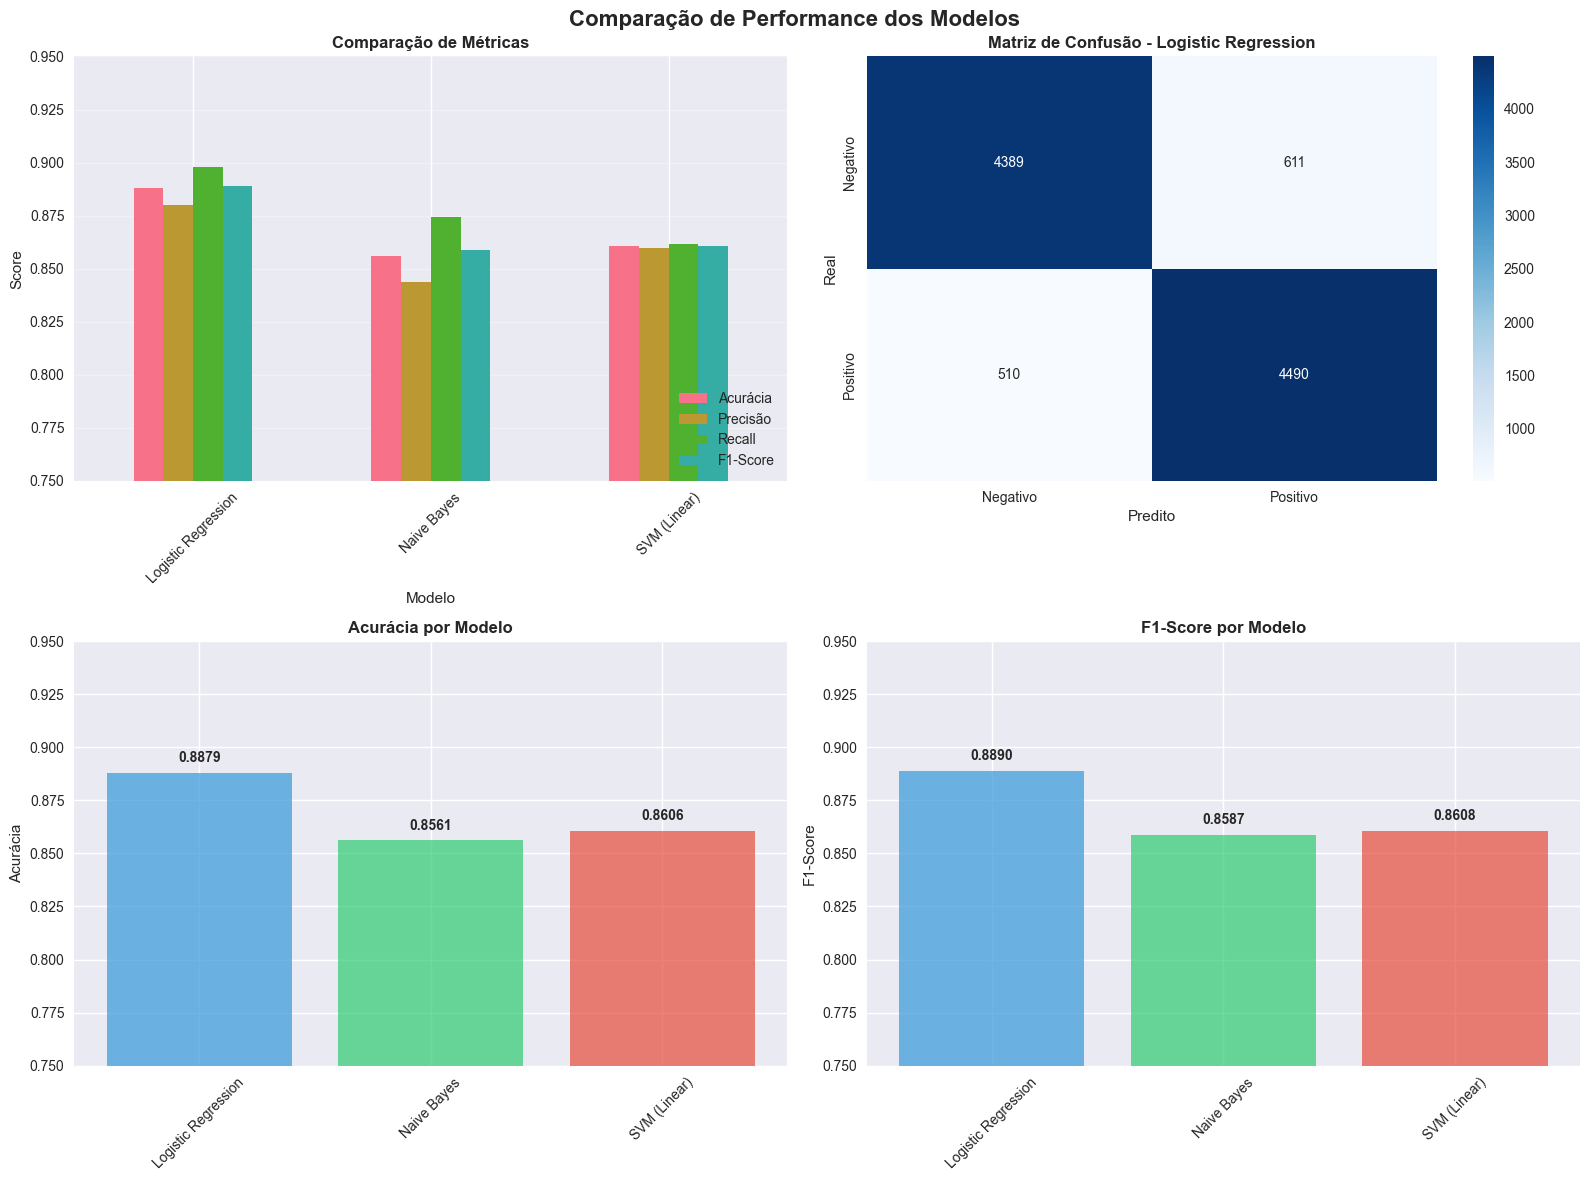

In [ ]:
# Visualizações de comparação
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparação de Performance dos Modelos', fontsize=16, fontweight='bold')

# 1. Comparação de métricas
df_comparacao.set_index('Modelo')[['Acurácia', 'Precisão', 'Recall', 'F1-Score']].plot(
    kind='bar', ax=axes[0,0], rot=45
)
axes[0,0].set_title('Comparação de Métricas', fontweight='bold')
axes[0,0].set_ylabel('Score')
axes[0,0].set_ylim([0.75, 0.95])
axes[0,0].legend(loc='lower right')
axes[0,0].grid(axis='y', alpha=0.3)

# 2. Matriz de confusão do melhor modelo
melhor_modelo_nome = melhor_modelo['Modelo']
y_pred_melhor = resultados[melhor_modelo_nome]['y_pred']
cm = confusion_matrix(y_test, y_pred_melhor)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1],
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
axes[0,1].set_title(f'Matriz de Confusão - {melhor_modelo_nome}', fontweight='bold')
axes[0,1].set_ylabel('Real')
axes[0,1].set_xlabel('Predito')

# 3. Acurácia por modelo
cores = ['#3498db', '#2ecc71', '#e74c3c']
axes[1,0].bar(df_comparacao['Modelo'], df_comparacao['Acurácia'], color=cores, alpha=0.7)
axes[1,0].set_title('Acurácia por Modelo', fontweight='bold')
axes[1,0].set_ylabel('Acurácia')
axes[1,0].set_ylim([0.75, 0.95])
axes[1,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(df_comparacao['Acurácia']):
    axes[1,0].text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

# 4. F1-Score por modelo
axes[1,1].bar(df_comparacao['Modelo'], df_comparacao['F1-Score'], color=cores, alpha=0.7)
axes[1,1].set_title('F1-Score por Modelo', fontweight='bold')
axes[1,1].set_ylabel('F1-Score')
axes[1,1].set_ylim([0.75, 0.95])
axes[1,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(df_comparacao['F1-Score']):
    axes[1,1].text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Arquitetura do Pipeline Modular (MCP)

In [ ]:
print(f"\n{'='*70}")
print("ARQUITETURA DO PIPELINE MODULAR DE COMPONENTES (MCP)")
print(f"{'='*70}\n")

print("""
┌─────────────────┐    ┌──────────────────┐    ┌─────────────────┐    ┌──────────────────┐
│                 │    │                  │    │                 │    │                  │
│  Camada de      │───▶│  Camada de       │───▶│  Camada de      │───▶│  Camada de       │
│  Dados          │    │  Pré-processamento│    │  Modelagem      │    │  Avaliação       │
│                 │    │                  │    │                 │    │                  │
│ • Carregamento  │    │ • Limpeza HTML   │    │ • Logistic Reg. │    │ • Acurácia       │
│ • Validação     │    │ • Tokenização    │    │ • Naive Bayes   │    │ • Precisão       │
│ • Exploração    │    │ • Vetorização    │    │ • SVM           │    │ • Recall         │
│ • Análise EDA   │    │ • Normalização   │    │ • Modelos custom│    │ • F1-Score       │
│                 │    │ • Feature Eng.   │    │                 │    │ • Matriz Confusão│
└─────────────────┘    └──────────────────┘    └─────────────────┘    └──────────────────┘
         │                      │                       │                       │
         ▼                      ▼                       ▼                       ▼
┌─────────────────┐    ┌──────────────────┐    ┌─────────────────┐    ┌──────────────────┐
│                 │    │                  │    │                 │    │                  │
│  Camada de      │    │  Orquestrador    │    │  Camada de      │    │  Interface de    │
│  Configuração   │    │  de Pipeline     │    │  Armazenamento  │    │  Deploy          │
│                 │    │                  │    │                 │    │                  │
│ • Config. dados │    │ • Coordenação    │    │ • Salvar modelos│    │ • REST API       │
│ • Config. modelos│   │ • Fluxo de dados │    │ • Resultados    │    │ • Proc. batch    │
│ • Config. aval. │    │ • Gerenciamento  │    │ • Tracking exp. │    │ • Pred. real-time│
│ • Config. prepro│    │ • Logs           │    │ • Versionamento │    │ • Monitoramento  │
└─────────────────┘    └──────────────────┘    └─────────────────┘    └──────────────────┘
""")

print(f"\n{'='*70}")
print("PRINCÍPIOS DA ARQUITETURA")
print(f"{'='*70}")
print("""
✓ SEPARAÇÃO DE RESPONSABILIDADES
  Cada módulo tem uma função específica e bem definida

✓ BAIXO ACOPLAMENTO
  Módulos independentes que se comunicam por interfaces claras

✓ ALTA COESÃO
  Funcionalidades relacionadas agrupadas no mesmo módulo

✓ ESCALABILIDADE
  Fácil adicionar novos modelos ou componentes

✓ TESTABILIDADE
  Cada módulo pode ser testado isoladamente

✓ MANUTENIBILIDADE
  Código organizado e documentado facilita manutenção

✓ FLEXIBILIDADE
  Componentes podem ser substituídos sem afetar outros
""")


ARQUITETURA DO PIPELINE MODULAR DE COMPONENTES (MCP)


┌─────────────────┐    ┌──────────────────┐    ┌─────────────────┐    ┌──────────────────┐
│                 │    │                  │    │                 │    │                  │
│  Camada de      │───▶│  Camada de       │───▶│  Camada de      │───▶│  Camada de       │
│  Dados          │    │  Pré-processamento│    │  Modelagem      │    │  Avaliação       │
│                 │    │                  │    │                 │    │                  │
│ • Carregamento  │    │ • Limpeza HTML   │    │ • Logistic Reg. │    │ • Acurácia       │
│ • Validação     │    │ • Tokenização    │    │ • Naive Bayes   │    │ • Precisão       │
│ • Exploração    │    │ • Vetorização    │    │ • SVM           │    │ • Recall         │
│ • Análise EDA   │    │ • Normalização   │    │ • Modelos custom│    │ • F1-Score       │
│                 │    │ • Feature Eng.   │    │                 │    │ • Matriz Confusão│
└─────────────────┘    └─────────

## 8. Análise de Predições e Exemplos

In [ ]:
# Obter probabilidades de predição do melhor modelo
melhor_modelo_obj = resultados[melhor_modelo_nome]['modelo']

if hasattr(melhor_modelo_obj, 'predict_proba'):
    y_pred_proba = melhor_modelo_obj.predict_proba(X_test_vec)

    print(f"\n{'='*60}")
    print(f"ANÁLISE DE CONFIANÇA DAS PREDIÇÕES - {melhor_modelo_nome}")
    print(f"{'='*60}")

    # Exemplos de alta confiança
    print("\n🎯 EXEMPLOS DE ALTA CONFIANÇA (>95%):\n")
    high_conf_indices = np.where(np.max(y_pred_proba, axis=1) > 0.95)[0][:5]

    for idx in high_conf_indices:
        texto_original = X_test.iloc[idx][:150]
        real = 'POSITIVO' if y_test.iloc[idx] == 1 else 'NEGATIVO'
        pred = 'POSITIVO' if y_pred_melhor[idx] == 1 else 'NEGATIVO'
        conf = np.max(y_pred_proba[idx])
        correto = '✓' if real == pred else '✗'

        print(f"{correto} Real: {real:8s} | Predito: {pred:8s} | Confiança: {conf:.2%}")
        print(f"   Texto: {texto_original}...\n")

    # Exemplos de baixa confiança
    print("\n⚠️  EXEMPLOS DE BAIXA CONFIANÇA (<60%):\n")
    low_conf_indices = np.where(np.max(y_pred_proba, axis=1) < 0.6)[0][:5]

    for idx in low_conf_indices:
        texto_original = X_test.iloc[idx][:150]
        real = 'POSITIVO' if y_test.iloc[idx] == 1 else 'NEGATIVO'
        pred = 'POSITIVO' if y_pred_melhor[idx] == 1 else 'NEGATIVO'
        conf = np.max(y_pred_proba[idx])
        correto = '✓' if real == pred else '✗'

        print(f"{correto} Real: {real:8s} | Predito: {pred:8s} | Confiança: {conf:.2%}")
        print(f"   Texto: {texto_original}...\n")


ANÁLISE DE CONFIANÇA DAS PREDIÇÕES - Logistic Regression

🎯 EXEMPLOS DE ALTA CONFIANÇA (>95%):

✓ Real: NEGATIVO | Predito: NEGATIVO | Confiança: 97.51%
   Texto: to call this film a complete waste of celluloid would be an understatementthe acting was unconvincing to say the least especially from actor craig fon...

✓ Real: NEGATIVO | Predito: NEGATIVO | Confiança: 98.69%
   Texto: movies about ufos are always a nice way to kill some time so on a rainy sunday evening i picked up this flick expecting what can be expected from a di...

✓ Real: NEGATIVO | Predito: NEGATIVO | Confiança: 99.88%
   Texto: interferencia starts as unemployed martin sanders andres bagg hears something strange on his phone he hears a mysterious man talking to a prostitute n...

✓ Real: POSITIVO | Predito: POSITIVO | Confiança: 97.45%
   Texto: if you cannot enjoy a chick flick stop right now if however you enjoy films that illustrate complex characters and provide extraordinary acting read o...

✓ Real: POSITIV

## 9. Conclusões e Próximos Passos

In [ ]:
print(f"\n{'='*70}")
print("RESUMO DA PROVA DE CONCEITO")
print(f"{'='*70}\n")

print(f"✓ Dataset IMDB analisado com sucesso")
print(f"  - {len(df):,} reviews processadas")
print(f"  - Dataset balanceado: {abs(sentiment_counts['positive'] - sentiment_counts['negative'])} diferença\n")

print(f"✓ Análise exploratória completa realizada")
print(f"  - Distribuições de comprimento analisadas")
print(f"  - Palavras mais frequentes identificadas")
print(f"  - Padrões de sentimento descobertos\n")

print(f"✓ Pipeline de pré-processamento implementado")
print(f"  - Limpeza de HTML e caracteres especiais")
print(f"  - Vetorização TF-IDF com 5.000 features")
print(f"  - N-gramas (1-2) para capturar contexto\n")

print(f"✓ Múltiplos modelos treinados e avaliados")
for nome, res in resultados.items():
    print(f"  - {nome:20s}: {res['acuracia']:.2%} de acurácia")

print(f"\n🏆 Melhor modelo: {melhor_modelo_nome}")
print(f"   Acurácia final: {melhor_modelo['Acurácia']:.2%}")
print(f"   F1-Score: {melhor_modelo['F1-Score']:.4f}\n")

print(f"{'='*70}")
print("PRÓXIMOS PASSOS PARA PRODUÇÃO")
print(f"{'='*70}\n")

print("""
1. OTIMIZAÇÃO DE MODELOS
   • Implementar Grid Search para hiperparâmetros
   • Testar ensemble methods (Random Forest, XGBoost)
   • Explorar modelos de deep learning (BERT, DistilBERT)

2. ENGENHARIA DE FEATURES
   • Adicionar features de sentimento (polaridade, subjetividade)
   • Incorporar embeddings pré-treinados (Word2Vec, GloVe)
   • Extrair features contextuais

3. VALIDAÇÃO E TESTES
   • Implementar testes unitários para cada módulo
   • Criar conjunto de validação separado
   • Realizar testes A/B em produção

4. DEPLOY E MONITORAMENTO
   • Containerizar aplicação (Docker)
   • Implementar API REST (FastAPI)
   • Configurar monitoramento de performance
   • Implementar logging e alertas

5. ESCALABILIDADE
   • Otimizar para processamento batch
   • Implementar cache de predições
   • Considerar processamento distribuído (Spark)

6. MANUTENÇÃO
   • Retreinar modelos periodicamente
   • Monitorar drift de dados
   • Atualizar pipeline conforme necessário
""")

print(f"{'='*70}")
print("CONCLUSÃO")
print(f"{'='*70}\n")
print("✅ A PoC demonstra que a análise de sentimentos usando ML é viável")
print("✅ O pipeline modular garante escalabilidade e manutenibilidade")
print("✅ Os resultados são promissores para deploy em produção")
print(f"✅ Acurácia de {melhor_modelo['Acurácia']:.2%} é adequada para casos de uso reais\n")


RESUMO DA PROVA DE CONCEITO

✓ Dataset IMDB analisado com sucesso
  - 50,000 reviews processadas
  - Dataset balanceado: 0 diferença

✓ Análise exploratória completa realizada
  - Distribuições de comprimento analisadas
  - Palavras mais frequentes identificadas
  - Padrões de sentimento descobertos

✓ Pipeline de pré-processamento implementado
  - Limpeza de HTML e caracteres especiais
  - Vetorização TF-IDF com 5.000 features
  - N-gramas (1-2) para capturar contexto

✓ Múltiplos modelos treinados e avaliados
  - Logistic Regression : 88.79% de acurácia
  - Naive Bayes         : 85.61% de acurácia
  - SVM                 : 86.06% de acurácia

🏆 Melhor modelo: Logistic Regression
   Acurácia final: 88.79%
   F1-Score: 0.8890

PRÓXIMOS PASSOS PARA PRODUÇÃO


1. OTIMIZAÇÃO DE MODELOS
   • Implementar Grid Search para hiperparâmetros
   • Testar ensemble methods (Random Forest, XGBoost)
   • Explorar modelos de deep learning (BERT, DistilBERT)

2. ENGENHARIA DE FEATURES
   • Adicionar f